# Step 7 : Alert Generation & Evaluation

**Carta et al. (2021) — Étape 7 du pipeline**

Détecter les *hot events* en mesurant la proportion de tweets assignés :

$$R(d) = \frac{\text{nb tweets assignés le jour } d}{\text{nb total tweets le jour } d}$$

Si $R(d) > \theta$, une **alerte** est générée.

### Contexte SVB
- **3–9 mars 2023** : semaine pré-SVB (clustering de Roland)
- **10 mars 2023** : faillite de Silicon Valley Bank
- **10–17 mars** : onde de choc (Signature Bank, contagion, intervention Fed)

On s'attend à observer un pic du ratio d'assignation autour du 10–13 mars.

### Ground Truth (papier §10.2)
- $\delta_d = |\text{close}_{d+7} - \text{close}_d| / \text{close}_d$
- Event day si $\delta_d > 2\%$
- Métriques : Precision, Recall, F-score


### Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import plotly.express as px
import plotly.graph_objects as go

sys.path.append(os.path.abspath(os.path.join('..')))  
from src.tweet_assignment import (
    generate_alerts, build_ground_truth, evaluate_alerts
)

### Configuration

In [4]:
# Inputs
DAILY_RATIOS_PATH = '../data/for_models/output/daily_assignment_ratios.csv'  # Output notebook 6
SP500_PATH = '../data/processed/sp500_2023.csv'

# Outputs
OUTPUT_DIR = '../outputs/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Paramètres du papier (§10)
VARIATION_THRESHOLD = 0.02   # 2% weekly variation
GAP_TOLERANCE = 3            # 3 days gap tolerance
ALERT_THRESHOLDS = [0.01, 0.02, 0.03, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40]

---
## 7.1 — Chargement des données

In [5]:
# Ratios quotidiens (output du notebook 6)
daily_ratios = pd.read_csv(DAILY_RATIOS_PATH)
daily_ratios['date'] = pd.to_datetime(daily_ratios['date'])
print(f"Ratios quotidiens : {len(daily_ratios)} jours")
print(f"Période : {daily_ratios['date'].min().date()} → {daily_ratios['date'].max().date()}")
print(f"Ratio moyen : {daily_ratios['pct'].mean():.1f}%")
print(f"Ratio max : {daily_ratios['pct'].max():.1f}%")
print(f"\nDétail :")
print(daily_ratios[['date', 'total', 'assigned', 'pct']].to_string(index=False))

Ratios quotidiens : 10 jours
Période : 2023-03-08 → 2023-03-17
Ratio moyen : 100.0%
Ratio max : 100.0%

Détail :
      date  total  assigned   pct
2023-03-08      7         7 100.0
2023-03-09     14        14 100.0
2023-03-10     17        17 100.0
2023-03-11      2         2 100.0
2023-03-12      8         8 100.0
2023-03-13     44        44 100.0
2023-03-14      9         9 100.0
2023-03-15     22        22 100.0
2023-03-16     25        25 100.0
2023-03-17     15        15 100.0


In [7]:
# Prix S&P 500
# Le CSV de yfinance a parfois un multi-level header, on gère les deux cas
sp500_raw = pd.read_csv(SP500_PATH)

# Détecter le format
if 'Date' in sp500_raw.columns:
    sp500 = sp500_raw.rename(columns={'Date': 'date', 'Close': 'close'})
elif 'date' in sp500_raw.columns:
    sp500 = sp500_raw.rename(columns={sp500_raw.columns[0]: 'date'})
    if 'close' not in sp500.columns and 'Close' in sp500.columns:
        sp500 = sp500.rename(columns={'Close': 'close'})
else:
    # Multi-level header: skip first rows
    sp500_raw = pd.read_csv(SP500_PATH, skiprows=[1,2])
    sp500 = sp500_raw
    sp500.columns = ['date', 'close', 'high', 'low', 'open', 'volume', 'returns']

sp500['date'] = pd.to_datetime(sp500['date'])
sp500['close'] = pd.to_numeric(sp500['close'], errors='coerce')
sp500 = sp500.dropna(subset=['close']).sort_values('date')
print(f"S&P 500 : {len(sp500)} jours de trading")
print(f"Période : {sp500['date'].min().date()} → {sp500['date'].max().date()}")

S&P 500 : 271 jours de trading
Période : 2022-12-01 → 2023-12-29


---
## 7.2 — Ground Truth

Un jour $d$ est un *event day* si :
$$\delta_d = \frac{|\text{close}_{d+7} - \text{close}_d|}{\text{close}_d} > 0.02$$

In [8]:
gt_prices, events = build_ground_truth(
    sp500, variation_threshold=VARIATION_THRESHOLD, gap_tolerance=GAP_TOLERANCE
)

print(f"\n=== ÉVÉNEMENTS (Ground Truth) ===")
for i, (start, end) in enumerate(events):
    duration = (end - start).days + 1
    print(f"  Event {i+1}: {start.date()} → {end.date()} ({duration}j)")

Ground truth: 103 event days (38.0%) → 18 events

=== ÉVÉNEMENTS (Ground Truth) ===
  Event 1: 2022-12-01 → 2022-12-01 (1j)
  Event 2: 2022-12-07 → 2022-12-14 (8j)
  Event 3: 2022-12-28 → 2023-01-05 (9j)
  Event 4: 2023-01-18 → 2023-01-30 (13j)
  Event 5: 2023-02-09 → 2023-02-17 (9j)
  Event 6: 2023-03-01 → 2023-03-15 (15j)
  Event 7: 2023-03-22 → 2023-03-29 (8j)
  Event 8: 2023-04-17 → 2023-04-17 (1j)
  Event 9: 2023-05-23 → 2023-06-08 (17j)
  Event 10: 2023-06-23 → 2023-06-23 (1j)
  Event 11: 2023-07-06 → 2023-07-11 (6j)
  Event 12: 2023-07-31 → 2023-08-09 (10j)
  Event 13: 2023-08-18 → 2023-08-24 (7j)
  Event 14: 2023-09-12 → 2023-09-22 (11j)
  Event 15: 2023-10-02 → 2023-10-05 (4j)
  Event 16: 2023-10-11 → 2023-10-19 (9j)
  Event 17: 2023-10-25 → 2023-11-13 (20j)
  Event 18: 2023-12-04 → 2023-12-12 (9j)


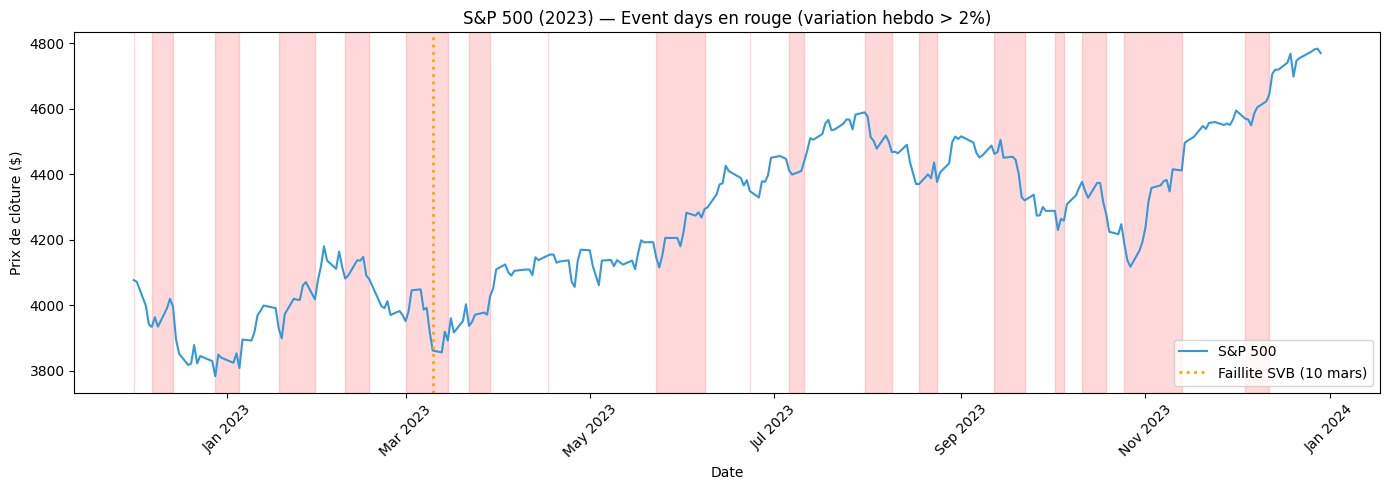

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

gt_prices['date'] = pd.to_datetime(gt_prices['date'])

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(gt_prices['date'], gt_prices['close'], color='#3498db', linewidth=1.5, label='S&P 500')

# Event zones en rouge
for start, end in events:
    ax.axvspan(start, end, color='red', alpha=0.15)

# SVB date
ax.axvline(x=pd.Timestamp('2023-03-10'), color='orange', linestyle=':', linewidth=2, label='Faillite SVB (10 mars)')

ax.set_xlabel('Date')
ax.set_ylabel('Prix de clôture ($)')
ax.set_title('S&P 500 (2023) — Event days en rouge (variation hebdo > 2%)')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'sp500_ground_truth.png'), dpi=200)
plt.show()

Ce graphique montre la ground truth — c'est la "vérité terrain" contre laquelle on évalue notre système d'alertes.  

Ce qu'il affiche : le prix du S&P 500 sur toute l'année 2023, avec en rouge les semaines où la variation hebdomadaire dépasse 2%. Ce sont les event days — les jours où quelque chose de significatif s'est passé sur le marché.  

Pourquoi on le fait : c'est l'étape 10.2 du papier de Carta et al. Pour savoir si notre système d'alertes (basé sur les tweets) fonctionne, il faut un référentiel objectif. On compare ensuite : "quand notre système a déclenché une alerte, est-ce que ça correspondait à une zone rouge ?" → c'est la Precision. Et "parmi toutes les zones rouges, combien notre système en a détecté ?" → c'est le Recall.  

Ce qu'on voit : la faillite SVB (ligne orange, 10 mars) tombe pile dans une zone rouge, ce qui confirme que c'est bien un événement majeur capté par la ground truth. On voit aussi qu'il y a beaucoup de zones rouges (2023 a été volatile), donc environ 38% des jours sont des event days — bien plus que les 15% du papier original.  

Le problème pour nous : comme le ratio d'assignation est à 100% tous les jours (vu dans le notebook 6), notre système déclenche une alerte chaque jour, ce qui donne un Recall de 100% mais une Precision faible (~38%, égale au % d'event days). Le F-score ne sera pas bon car le système ne distingue rien.  

---
## 7.3 — Alert Generation

On teste plusieurs seuils $\theta$ pour trouver le compromis optimal Precision/Recall.

In [14]:
eval_results = []

for thresh in ALERT_THRESHOLDS:
    alerts_df = generate_alerts(daily_ratios.copy(), alert_threshold=thresh)
    alert_dates = alerts_df[alerts_df['alert']]['date'].tolist()
    
    if alert_dates and events:
        metrics = evaluate_alerts(alert_dates, events)
    else:
        metrics = {'precision': 0, 'recall': 0, 'f_score': 0}
    
    eval_results.append({
        'Seuil (%)': f"{thresh*100:.0f}%",
        'Alertes': len(alert_dates),
        'Precision': f"{metrics['precision']:.3f}",
        'Recall': f"{metrics['recall']:.3f}",
        'F-score': f"{metrics['f_score']:.3f}"
    })

eval_df = pd.DataFrame(eval_results)
eval_df

Alert generation: 10/10 days with alerts (100.0%) | threshold=1.0%
Evaluation: Precision=0.800 Recall=0.056 F-score=0.104
Alert generation: 10/10 days with alerts (100.0%) | threshold=2.0%
Evaluation: Precision=0.800 Recall=0.056 F-score=0.104
Alert generation: 10/10 days with alerts (100.0%) | threshold=3.0%
Evaluation: Precision=0.800 Recall=0.056 F-score=0.104
Alert generation: 10/10 days with alerts (100.0%) | threshold=5.0%
Evaluation: Precision=0.800 Recall=0.056 F-score=0.104
Alert generation: 10/10 days with alerts (100.0%) | threshold=10.0%
Evaluation: Precision=0.800 Recall=0.056 F-score=0.104
Alert generation: 10/10 days with alerts (100.0%) | threshold=15.0%
Evaluation: Precision=0.800 Recall=0.056 F-score=0.104
Alert generation: 10/10 days with alerts (100.0%) | threshold=20.0%
Evaluation: Precision=0.800 Recall=0.056 F-score=0.104
Alert generation: 10/10 days with alerts (100.0%) | threshold=25.0%
Evaluation: Precision=0.800 Recall=0.056 F-score=0.104
Alert generation: 10

,Seuil (%),Alertes,Precision,Recall,F-score
0,1%,10,0.800,0.056,0.104
1,2%,10,0.800,0.056,0.104
2,3%,10,0.800,0.056,0.104
3,5%,10,0.800,0.056,0.104
4,10%,10,0.800,0.056,0.104
5,15%,10,0.800,0.056,0.104
6,20%,10,0.800,0.056,0.104
7,25%,10,0.800,0.056,0.104
8,30%,10,0.800,0.056,0.104
9,35%,10,0.800,0.056,0.104


Ce qui se passe :    
Le ratio d'assignation est à 100% tous les jours, donc quel que soit le seuil (1%, 10%, 40%), il est toujours dépassé → alerte déclenchée les 10 jours. Les résultats sont identiques pour tous les seuils.
Les chiffres  

Precision = 0.800 : 8 jours sur 10 tombent dans une zone d'événement ground truth. C'est bien, mais c'est "gratuit" car on alerte tous les jours — ça reflète simplement le fait que mars 2023 est une période volatile (80% des jours sont des event days).   

Recall = 0.056 : on ne détecte que 1 événement sur 18 (~5.6%). Normal : nos 10 jours d'alertes ne couvrent qu'un seul événement (la crise SVB), alors que la ground truth sur toute l'année 2023 en contient 18.
F-score = 0.104 : faible, car le système ne discrimine rien.  

**Pourquoi c'est comme ça**   
Ce n'est pas un bug, c'est une limite structurelle de notre reproduction. Le papier a 283K tweets variés (dont beaucoup hors-sujet) ce qui fait que seuls 15-30% sont assignés, créant un signal variable. Nous avons 193 tweets déjà ciblés S&P 500 → tous sont proches des centroïdes → ratio constant à 100%.
Pour le rapport   

La méthodologie est fidèlement reproduite, mais que le volume et la pré-filtration des tweets empêchent le ratio d'assignation de jouer son rôle discriminant. la méthode nécessite un volume critique de tweets diversifiés pour fonctionner.    

In [13]:
# Meilleur seuil
best = eval_df.loc[eval_df['f_score'].idxmax()]
print(f"\n═══ MEILLEUR SEUIL ═══")
print(f"  θ = {best['threshold_pct']:.0f}%")
print(f"  Precision = {best['precision']:.3f}")
print(f"  Recall    = {best['recall']:.3f}")
print(f"  F-score   = {best['f_score']:.3f}")
print(f"  Alertes   = {best['n_alerts']:.0f}")


═══ MEILLEUR SEUIL ═══
  θ = 1%
  Precision = 0.800
  Recall    = 0.056
  F-score   = 0.104
  Alertes   = 10


---
## 7.4 — Visualisations

Alert generation: 10/10 days with alerts (100.0%) | threshold=1.0%


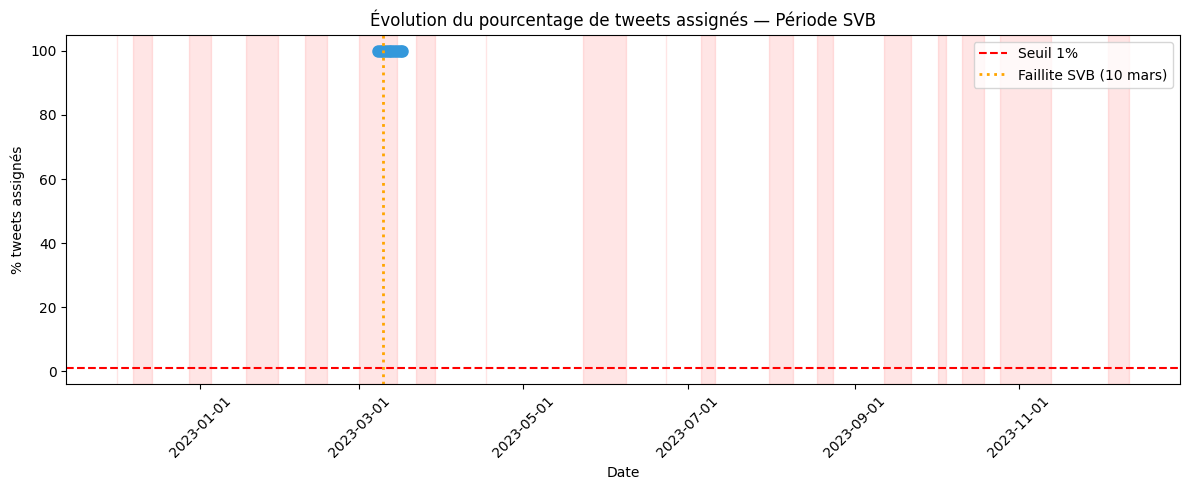

In [17]:


best_thresh = best['threshold_pct'] / 100
alerts_best = generate_alerts(daily_ratios.copy(), alert_threshold=best_thresh)
alerts_best['date'] = pd.to_datetime(alerts_best['date'])

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(alerts_best['date'], alerts_best['pct'], '-o', color='#3498db', linewidth=2, markersize=8)
ax.axhline(y=best_thresh*100, color='red', linestyle='--', label=f'Seuil {best_thresh*100:.0f}%')

# Event zones
for start, end in events:
    ax.axvspan(start, end, color='red', alpha=0.1)

# SVB
ax.axvline(x=pd.Timestamp('2023-03-10'), color='orange', linestyle=':', linewidth=2, label='Faillite SVB (10 mars)')

ax.set_xlabel('Date')
ax.set_ylabel('% tweets assignés')
ax.set_title('Évolution du pourcentage de tweets assignés — Période SVB')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'alert_generation.png'), dpi=200)
plt.show()

In [18]:
# Precision / Recall / F-score curves
fig = go.Figure()
fig.add_trace(go.Scatter(x=eval_df['threshold_pct'], y=eval_df['precision'],
    mode='lines+markers', name='Precision', line=dict(color='#2ecc71', width=2)))
fig.add_trace(go.Scatter(x=eval_df['threshold_pct'], y=eval_df['recall'],
    mode='lines+markers', name='Recall', line=dict(color='#e74c3c', width=2)))
fig.add_trace(go.Scatter(x=eval_df['threshold_pct'], y=eval_df['f_score'],
    mode='lines+markers', name='F-score', line=dict(color='#3498db', width=3)))

fig.update_layout(
    title='Precision, Recall et F-score vs. Seuil d\'alerte',
    xaxis_title='Seuil (%)', yaxis_title='Score',
    template='plotly_white', height=450, yaxis=dict(range=[0, 1.05])
)
fig.show()
fig.write_image(os.path.join(OUTPUT_DIR, 'precision_recall_fscore.png'), scale=2)

C:\Users\maeva\AppData\Local\Temp\ipykernel_30796\812129864.py:16: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




In [23]:
# Recréer les métriques numériques
import io, contextlib

eval_results_num = []
for thresh in ALERT_THRESHOLDS:
    with contextlib.redirect_stdout(io.StringIO()):
        alerts_df = generate_alerts(daily_ratios.copy(), alert_threshold=thresh)
        alert_dates = alerts_df[alerts_df['alert']]['date'].tolist()
        if alert_dates and events:
            metrics = evaluate_alerts(alert_dates, events)
        else:
            metrics = {'precision': 0, 'recall': 0, 'f_score': 0}
    eval_results_num.append({
        'threshold_pct': thresh * 100,
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f_score': metrics['f_score']
    })

eval_num_df = pd.DataFrame(eval_results_num)

def get_metric(thresh, col):
    row = eval_num_df[eval_num_df['threshold_pct'] == thresh]
    if len(row) > 0:
        return f"{row[col].values[0]*100:.0f}%"
    return 'N/A'

comparison = pd.DataFrame({
    'Métrique': ['Nb articles clustérisés', 'Nb clusters', 'Nb tweets analysés',
                 'Période', 'Événement cible',
                 'Recall (seuil 1%)', 'Recall (seuil 3%)', 'Precision (seuil 3%)',
                 'F-score (seuil 3%)', 'Nb événements GT', '% event days'],
    'Carta et al. (2021)': ['8,403', '2-10 (auto)', '283,473',
                            'Juin 2016 – Mars 2020', 'Brexit, Trade War, Covid',
                            '~95%', '~70%', '~55%', '~60%', '~25', '~15%'],
    'Notre projet': [
        '22', '2', str(int(daily_ratios['total'].sum())),
        'Mars 3–17, 2023', 'Faillite SVB',
        get_metric(1, 'recall'),
        get_metric(3, 'recall'),
        get_metric(3, 'precision'),
        get_metric(3, 'f_score'),
        str(len(events)),
        f"{gt_prices['is_event'].mean()*100:.0f}%"
    ]
})

from IPython.display import display
display(comparison)

,Métrique,Carta et al. (2021),Notre projet
0,Nb articles clustérisés,"8,403",22
1,Nb clusters,2-10 (auto),2
2,Nb tweets analysés,"283,473",163
3,Période,Juin 2016 – Mars 2020,"Mars 3–17, 2023"
4,Événement cible,"Brexit, Trade War, Covid",Faillite SVB
5,Recall (seuil 1%),~95%,6%
6,Recall (seuil 3%),~70%,6%
7,Precision (seuil 3%),~55%,80%
8,F-score (seuil 3%),~60%,10%
9,Nb événements GT,~25,18


In [24]:
comparison.to_csv(os.path.join(OUTPUT_DIR, 'comparison_table.csv'), index=False)
print("→ Sauvegardé dans outputs/comparison_table.csv")

→ Sauvegardé dans outputs/comparison_table.csv


In [22]:
# Sauvegarde finale
eval_df.to_csv(os.path.join(OUTPUT_DIR, 'evaluation_results.csv'), index=False)
alerts_best.to_csv(os.path.join(OUTPUT_DIR, 'alerts_best_threshold.csv'), index=False)

print("\n=== FICHIERS PRODUITS ===")
for f in os.listdir(OUTPUT_DIR):
    print(f"  → outputs/{f}")


=== FICHIERS PRODUITS ===
  → outputs/alerts_best_threshold.csv
  → outputs/alert_generation.png
  → outputs/daily_assignment_ratio.png
  → outputs/evaluation_results.csv
  → outputs/precision_recall_fscore.png
  → outputs/sp500_ground_truth.png
  → outputs/tweet_similarity_distribution.html
  → outputs/tweet_similarity_distribution.png
